In [2]:
from glob import glob
from itertools import chain
from collections import Counter
from pprint import pprint

id2class_map = {
    '0': 'with helmet', 
    '1': 'without helmet', 
    '2': 'rider', 
    '3': 'number_plate'
}
main_path = "datasets"  

def print_data_size(folder_type):
    data_size = len(glob(f'{main_path}/{folder_type}/labels/*.txt'))
    print(f'{folder_type} data count: {data_size}')
    
def print_class_count(folder_type):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.append([row.split()[0] for row in open(file, "r")])
    counter = Counter(list(chain(*class_list)))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}':v for k, v in counter.items()})
    print()

print_data_size('train')
print_class_count('train')
print_data_size('val')
print_class_count('val')  

train data count: 104
-- data class count
{'0. with helmet': 64,
 '1. without helmet': 93,
 '2. rider': 120,
 '3. number_plate': 116}

val data count: 20
-- data class count
{'0. with helmet': 13,
 '1. without helmet': 15,
 '2. rider': 23,
 '3. number_plate': 22}



In [3]:
import os
import cv2
from matplotlib import pyplot as plt

main_path = f"datasets"  

def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    ''' get bbox and label information from label txt files '''
    
    # read file from path
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()
    
    # extract bboxes and labels from the label file
    bboxes = [
        [float(n) for n in line.split()[1:]]
        for line in lines
    ]
    labels = [id2class_map[line.split()[0]] for line in lines]
    
    return bboxes, labels
    
def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    # reference
    
    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox
    
    # calculate the coordinates of the bounding box
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2
    
    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)
    
    return x_min, y_min, x_max, y_max

class2color_map = {
    'with helmet': (0,255,128),
    'without helmet': (255,51,51),
    'rider': (51,255,255),
    'number_plate': (224,102,255)
}

def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):
        
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)
        
        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)
        
        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

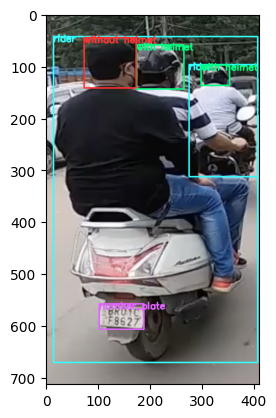

In [4]:
plot_image(image_name='new36')


In [5]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = YOLO('models/yolov8n.pt')

# Display model information (optional)
model.info()

YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [6]:
import yaml

# read the content of coco128.yaml
with open(os.path.join(main_path, 'coco128.yaml'), 'r') as file:
    print(file.read())

train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]


In [7]:
# creata the yaml based on coco128 for model training
data = {
    'path' : '../datasets/',
    'train': '../datasets/train',
    'val': '../datasets/val',
    'nc': 4,
    'names': [
        'with helmet',
        'without helmet',
        'rider',
        'number plate'
    ]
}

with open('data.yaml', 'w') as file:
    yaml.dump(data, file)

# check the content of data.yaml
with open('data.yaml', 'r') as file:
    print(file.read())

names:
- with helmet
- without helmet
- rider
- number plate
nc: 4
path: ../datasets/
train: ../datasets/train
val: ../datasets/val



In [8]:
# disable wandb
os.environ['WANDB_MODE'] = "disabled"


# command to train the YOLOv8 model
model.train(
    data='data.yaml',
    epochs=50,
    workers=1,
    batch=8,
)

Ultralytics YOLOv8.2.67  Python-3.8.0 torch-2.4.0+cpu CPU (AMD Ryzen 5 5600 6-Core Processor)
engine\trainer: task=detect, mode=train, model=models/yolov8n.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

d:\Manythings\CodePractice\helmet_detection\yolov8_env\lib\site-packages\ultralytics\engine\trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning D:\Manythings\CodePractice\helmet_detection\datasets\train\labels.cache... 102 images, 0 backgrounds, 2 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]

train: WARNING  D:\Manythings\CodePractice\helmet_detection\datasets\train\images\new128.jpg: ignoring corrupt image/label: cannot identify image file 'D:\\Manythings\\CodePractice\\helmet_detection\\datasets\\train\\images\\new128.jpg'
train: WARNING  D:\Manythings\CodePractice\helmet_detection\datasets\train\images\new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'jpeg', 'pfm', 'tiff', 'webp', 'mpo', 'bmp', 'tif', 'dng', 'jpg', 'png'}
videos: {'wmv', 'mpg', 'ts', 'asf', 'webm', 'avi', 'mpeg', 'mov', 'mkv', 'gif', 'mp4', 'm4v'}



val: Scanning D:\Manythings\CodePractice\helmet_detection\datasets\val\labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.017       3.42      1.276         54        640: 100%|██████████| 13/13 [00:30<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]

                   all         20         73     0.0207      0.413       0.23       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.8999       2.38      1.166         38        640: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

                   all         20         73     0.0275      0.455      0.232      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.8946      1.578      1.125         45        640: 100%|██████████| 13/13 [00:30<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         20         73      0.953      0.234      0.677      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.8878      1.376      1.125         50        640: 100%|██████████| 13/13 [00:30<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         20         73      0.939      0.298      0.771      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.8513      1.286      1.082         36        640: 100%|██████████| 13/13 [00:28<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         20         73      0.785      0.318      0.816      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.8847      1.156      1.077         46        640: 100%|██████████| 13/13 [00:28<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         20         73      0.839      0.452      0.832      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.9117      1.138      1.073         43        640: 100%|██████████| 13/13 [00:29<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         20         73      0.879       0.61      0.898      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.8732      1.112      1.083         60        640: 100%|██████████| 13/13 [00:29<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         20         73      0.836       0.56      0.877       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.8744      1.063      1.105         47        640: 100%|██████████| 13/13 [00:29<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

                   all         20         73      0.779      0.747      0.908      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      0.824     0.9723      1.049         59        640: 100%|██████████| 13/13 [00:24<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         20         73      0.796      0.837      0.913       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.8252       1.02      1.059         28        640: 100%|██████████| 13/13 [00:24<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         20         73        0.8      0.887      0.906      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.8544      0.999      1.062         44        640: 100%|██████████| 13/13 [00:24<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         20         73      0.834      0.847      0.918      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      0.841      0.959      1.063         39        640: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         20         73      0.786      0.854      0.929      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.8002     0.8808      1.012         45        640: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         20         73      0.846      0.852      0.929       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.7576     0.8572      1.021         49        640: 100%|██████████| 13/13 [00:25<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         20         73       0.88       0.87      0.902      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.7517     0.8451      1.021         46        640: 100%|██████████| 13/13 [00:29<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         20         73      0.848      0.845      0.895      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.7175     0.8236       1.01         50        640: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all         20         73       0.92      0.809      0.914      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.7624     0.8666      1.009         38        640: 100%|██████████| 13/13 [00:30<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all         20         73      0.902       0.87      0.918      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.7177     0.8216      1.013         38        640: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         20         73      0.947      0.873      0.924      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.7098     0.7896     0.9902         44        640: 100%|██████████| 13/13 [00:25<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

                   all         20         73      0.914      0.879      0.943      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.6912     0.7666      0.993         54        640: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         20         73      0.923      0.914      0.944      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.7041     0.7929     0.9948         36        640: 100%|██████████| 13/13 [00:29<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all         20         73      0.908      0.884       0.92      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.6815     0.7478      0.976         38        640: 100%|██████████| 13/13 [00:29<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         20         73      0.908      0.911      0.923      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.6616     0.7317     0.9703         31        640: 100%|██████████| 13/13 [00:29<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         20         73      0.904      0.918      0.929      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.6604     0.7326     0.9577         48        640: 100%|██████████| 13/13 [00:29<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         20         73      0.928      0.922      0.922      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.6457     0.7549      0.994         33        640: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         20         73       0.94      0.905      0.927      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.6618     0.7143     0.9773         47        640: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

                   all         20         73      0.938      0.919      0.927      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.6725     0.7044     0.9788         53        640: 100%|██████████| 13/13 [00:27<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all         20         73      0.891      0.898      0.926      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.6547      0.692     0.9735         38        640: 100%|██████████| 13/13 [00:27<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         20         73      0.866      0.923      0.924      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.6478     0.7032     0.9848         43        640: 100%|██████████| 13/13 [00:28<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all         20         73      0.918      0.881      0.915      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.6382     0.6806     0.9697         45        640: 100%|██████████| 13/13 [00:31<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

                   all         20         73      0.893      0.918      0.917       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.6147     0.6445     0.9416         52        640: 100%|██████████| 13/13 [00:30<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         20         73      0.927      0.898      0.917      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.6381     0.6717     0.9555         37        640: 100%|██████████| 13/13 [00:26<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         20         73      0.927      0.921      0.922      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G       0.63     0.6427     0.9585         56        640: 100%|██████████| 13/13 [00:30<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]

                   all         20         73       0.93      0.917      0.931      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.6213     0.6488     0.9777         53        640: 100%|██████████| 13/13 [00:29<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

                   all         20         73      0.923      0.923      0.932      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.5829     0.6231     0.9573         37        640: 100%|██████████| 13/13 [00:30<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all         20         73      0.913      0.923      0.946      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.6115     0.6083     0.9547         43        640: 100%|██████████| 13/13 [00:29<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         20         73       0.93        0.9      0.949      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.5842     0.6144     0.9692         43        640: 100%|██████████| 13/13 [00:28<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         20         73      0.897      0.935      0.949      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.5884     0.6056     0.9457         48        640: 100%|██████████| 13/13 [00:24<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         20         73      0.925      0.917      0.941      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.5722     0.5976     0.9552         65        640: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         20         73      0.926      0.912      0.939      0.769


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.5543     0.7974     0.8872         20        640: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         20         73      0.926      0.913      0.924      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.5121     0.7138     0.8874         20        640: 100%|██████████| 13/13 [00:25<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         20         73      0.928      0.917      0.921       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.5294     0.6983     0.8871         22        640: 100%|██████████| 13/13 [00:24<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         20         73      0.907       0.92      0.908      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      0.502     0.6886     0.8794         19        640: 100%|██████████| 13/13 [00:23<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         20         73      0.903      0.923      0.911      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.5142     0.6673     0.8894         21        640: 100%|██████████| 13/13 [00:24<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         20         73      0.907      0.923      0.919      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.5044     0.6621     0.8773         28        640: 100%|██████████| 13/13 [00:24<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         20         73       0.93      0.899      0.929      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.5103     0.6437     0.8797         24        640: 100%|██████████| 13/13 [00:24<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all         20         73      0.911      0.932      0.935      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.5164     0.6441     0.8891         24        640: 100%|██████████| 13/13 [00:24<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

                   all         20         73      0.929      0.924      0.935      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.5137     0.6265     0.8574         27        640: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         20         73      0.923      0.937      0.942      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.5067     0.6335      0.897         23        640: 100%|██████████| 13/13 [00:27<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]

                   all         20         73       0.93      0.942      0.943      0.786



50 epochs completed in 0.419 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.67  Python-3.8.0 torch-2.4.0+cpu CPU (AMD Ryzen 5 5600 6-Core Processor)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


                   all         20         73      0.929      0.942      0.942      0.786
           with helmet         12         13      0.999      0.923      0.925       0.69
        without helmet         10         15      0.808      0.933      0.893      0.702
                 rider         20         23      0.911      0.913      0.957      0.905
          number plate         20         22          1      0.999      0.995      0.847
Speed: 1.7ms preprocess, 87.2ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000254D428CA00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [9]:
import shutil
import os


source_path = 'runs/detect/train/weights/best.pt'
destination_dir = 'models'
destination_path = os.path.join(destination_dir, 'best.pt')


if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# 複製文件
shutil.copyfile(source_path, destination_path)

print(f"Successfully copied {source_path} to {destination_path}")


Successfully copied runs/detect/train/weights/best.pt to models\best.pt


In [10]:
model = YOLO('models/best.pt')

In [11]:
# use results from `model.predict()` for plotting 
def plot_pred_image(image_name, id2class_map=id2class_map, class2color_map=class2color_map):
    image_path = os.path.join(main_path, 'val', 'images', f'{image_name}.jpg')
    
    # get plot elements (bbox, labels) from `predict()` results
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]
    for bbox, label in zip(bboxes, labels):
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]
        
        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)
        
        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

prediction ↓

image 1/1 d:\Manythings\CodePractice\helmet_detection\datasets\val\images\new94.jpg: 608x640 1 with helmet, 1 rider, 1 number plate, 78.1ms
Speed: 3.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


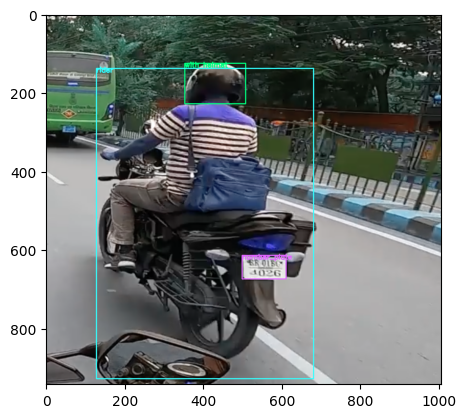

actual image ↓


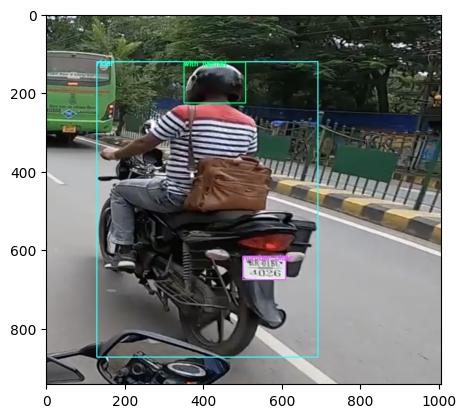

In [12]:
image_name = 'new94'
print('prediction ↓')
plot_pred_image(image_name=image_name)
print('actual image ↓')
plot_image(image_name=image_name, data_type='val')

In [13]:
from tqdm import tqdm

In [18]:
input_dir = 'input'
output_dir = 'output'
input_video_path = os.path.join(input_dir, 'input_video.mp4')
output_video_path = os.path.join(output_dir, 'output_video.mp4')
model_path = 'models/best.pt'

def process_video(input_video_path,output_video_path,model_path):
    model = YOLO(model_path)
    os.makedirs(os.path.dirname(output_video_path),exist_ok=True)
    
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video file: {input_video_path}")
    
    frame_width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out =cv2.VideoWriter(output_video_path,fourcc,fps,(frame_width,frame_height))
    
    for _ in tqdm(range(total_frames),desc="Processing video"):
        ret,frame =cap.read()
        if not ret:
            break
            
        results =model(frame)
        
        annotated_frame = results[0].plot()
        
        out.write(annotated_frame)
    
    cap.release()
    out.release()
    
    print(f"Detection video saved at: {output_video_path}")
    




In [19]:

process_video(input_video_path, output_video_path, model_path)

Processing video:   0%|          | 0/965 [00:00<?, ?it/s]


0: 640x384 (no detections), 83.1ms
Speed: 3.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   0%|          | 1/965 [00:01<25:00,  1.56s/it]


0: 640x384 (no detections), 40.0ms
Speed: 2.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 6 riders, 2 number plates, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 with helmets, 4 riders, 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   0%|          | 4/965 [00:01<05:18,  3.01it/s]


0: 640x384 3 with helmets, 6 riders, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 with helmets, 4 riders, 1 number plate, 51.0ms
Speed: 2.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   1%|          | 6/965 [00:01<03:21,  4.75it/s]


0: 640x384 1 with helmet, 4 riders, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 5 riders, 1 number plate, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 1 rider, 1 number plate, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   1%|          | 9/965 [00:01<02:06,  7.58it/s]


0: 640x384 1 with helmet, 2 riders, 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 with helmets, 3 riders, 1 number plate, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   1%|          | 11/965 [00:02<01:42,  9.34it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 71.1ms
Speed: 2.0ms preprocess, 71.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 1 rider, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   1%|▏         | 13/965 [00:02<01:29, 10.69it/s]


0: 640x384 2 with helmets, 1 rider, 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 1 rider, 1 number plate, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 1 rider, 1 number plate, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   2%|▏         | 16/965 [00:02<01:11, 13.26it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 2 riders, 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   2%|▏         | 19/965 [00:02<01:00, 15.68it/s]


0: 640x384 1 rider, 1 number plate, 37.0ms
Speed: 2.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 48.0ms
Speed: 2.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   2%|▏         | 22/965 [00:02<00:56, 16.80it/s]


0: 640x384 1 rider, 1 number plate, 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   3%|▎         | 25/965 [00:02<00:51, 18.22it/s]


0: 640x384 2 number plates, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 45.0ms
Speed: 7.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 number plates, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   3%|▎         | 28/965 [00:02<00:49, 18.82it/s]


0: 640x384 1 rider, 1 number plate, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   3%|▎         | 31/965 [00:03<00:47, 19.52it/s]


0: 640x384 2 riders, 1 number plate, 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   4%|▎         | 34/965 [00:03<00:48, 19.31it/s]


0: 640x384 1 rider, 1 number plate, 64.1ms
Speed: 17.0ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 104.1ms
Speed: 1.0ms preprocess, 104.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 40.0ms
Speed: 2.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   4%|▍         | 37/965 [00:03<00:57, 16.27it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 48.0ms
Speed: 2.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   4%|▍         | 39/965 [00:03<00:54, 16.85it/s]


0: 640x384 1 rider, 2 number plates, 61.1ms
Speed: 1.0ms preprocess, 61.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 3 number plates, 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   4%|▍         | 41/965 [00:03<00:55, 16.77it/s]


0: 640x384 1 with helmet, 1 rider, 2 number plates, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   4%|▍         | 43/965 [00:03<00:53, 17.38it/s]


0: 640x384 1 rider, 2 number plates, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 2 number plates, 130.1ms
Speed: 1.0ms preprocess, 130.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   5%|▍         | 45/965 [00:03<01:02, 14.72it/s]


0: 640x384 1 number plate, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 number plates, 48.0ms
Speed: 2.0ms preprocess, 48.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   5%|▍         | 48/965 [00:04<00:56, 16.19it/s]


0: 640x384 1 number plate, 49.1ms
Speed: 1.0ms preprocess, 49.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   5%|▌         | 50/965 [00:04<00:53, 17.03it/s]


0: 640x384 1 number plate, 41.0ms
Speed: 0.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   5%|▌         | 53/965 [00:04<00:50, 18.21it/s]


0: 640x384 1 rider, 1 number plate, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 2 number plates, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   6%|▌         | 56/965 [00:04<00:47, 19.01it/s]


0: 640x384 1 rider, 1 number plate, 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 2 number plates, 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   6%|▌         | 58/965 [00:04<00:48, 18.80it/s]


0: 640x384 1 number plate, 85.1ms
Speed: 1.0ms preprocess, 85.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 2 number plates, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   6%|▌         | 60/965 [00:04<00:51, 17.50it/s]


0: 640x384 2 number plates, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   7%|▋         | 63/965 [00:04<00:49, 18.07it/s]


0: 640x384 1 number plate, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   7%|▋         | 65/965 [00:05<00:48, 18.43it/s]


0: 640x384 1 number plate, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   7%|▋         | 67/965 [00:05<00:48, 18.68it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 39.0ms
Speed: 2.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   7%|▋         | 70/965 [00:05<00:45, 19.77it/s]


0: 640x384 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   8%|▊         | 73/965 [00:05<00:44, 20.07it/s]


0: 640x384 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   8%|▊         | 76/965 [00:05<00:42, 20.86it/s]


0: 640x384 1 with helmet, 1 rider, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   8%|▊         | 79/965 [00:05<00:43, 20.35it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 38.0ms
Speed: 0.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 2 number plates, 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 2 number plates, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   8%|▊         | 82/965 [00:05<00:42, 20.94it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 2 number plates, 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 2 number plates, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   9%|▉         | 85/965 [00:05<00:42, 20.75it/s]


0: 640x384 1 number plate, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 44.0ms
Speed: 18.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 46.9ms
Speed: 0.0ms preprocess, 46.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   9%|▉         | 88/965 [00:06<00:45, 19.26it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:   9%|▉         | 91/965 [00:06<00:43, 20.07it/s]


0: 640x384 1 number plate, 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 58.1ms
Speed: 1.0ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  10%|▉         | 94/965 [00:06<00:43, 19.92it/s]


0: 640x384 1 rider, 1 number plate, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 36.0ms
Speed: 3.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  10%|█         | 97/965 [00:06<00:42, 20.64it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 51.0ms
Speed: 1.7ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  10%|█         | 100/965 [00:06<00:42, 20.58it/s]


0: 640x384 1 rider, 1 number plate, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  11%|█         | 103/965 [00:06<00:40, 21.09it/s]


0: 640x384 1 number plate, 48.0ms
Speed: 0.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 38.0ms
Speed: 2.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  11%|█         | 106/965 [00:06<00:40, 21.00it/s]


0: 640x384 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 39.0ms
Speed: 2.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  11%|█▏        | 109/965 [00:07<00:39, 21.44it/s]


0: 640x384 (no detections), 55.0ms
Speed: 1.0ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  12%|█▏        | 112/965 [00:07<00:41, 20.76it/s]


0: 640x384 1 rider, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  12%|█▏        | 115/965 [00:07<00:41, 20.27it/s]


0: 640x384 (no detections), 91.1ms
Speed: 1.0ms preprocess, 91.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  12%|█▏        | 118/965 [00:07<00:45, 18.64it/s]


0: 640x384 (no detections), 39.0ms
Speed: 2.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  12%|█▏        | 120/965 [00:07<00:44, 18.84it/s]


0: 640x384 2 riders, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 38.5ms
Speed: 1.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  13%|█▎        | 123/965 [00:07<00:43, 19.54it/s]


0: 640x384 1 rider, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 56.0ms
Speed: 1.0ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  13%|█▎        | 125/965 [00:07<00:43, 19.29it/s]


0: 640x384 1 rider, 46.0ms
Speed: 0.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  13%|█▎        | 127/965 [00:08<00:43, 19.22it/s]


0: 640x384 1 rider, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 65.1ms
Speed: 1.0ms preprocess, 65.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  13%|█▎        | 129/965 [00:08<00:46, 18.16it/s]


0: 640x384 1 rider, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  14%|█▎        | 132/965 [00:08<00:43, 19.35it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  14%|█▍        | 135/965 [00:08<00:41, 20.00it/s]


0: 640x384 1 rider, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  14%|█▍        | 138/965 [00:08<00:39, 20.72it/s]


0: 640x384 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 57.1ms
Speed: 1.0ms preprocess, 57.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  15%|█▍        | 141/965 [00:08<00:40, 20.21it/s]


0: 640x384 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  15%|█▍        | 144/965 [00:08<00:39, 20.71it/s]


0: 640x384 (no detections), 64.1ms
Speed: 1.0ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  15%|█▌        | 147/965 [00:09<00:41, 19.85it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 146.1ms
Speed: 2.0ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  16%|█▌        | 150/965 [00:09<00:48, 16.67it/s]


0: 640x384 (no detections), 53.0ms
Speed: 3.0ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  16%|█▌        | 152/965 [00:09<00:48, 16.92it/s]


0: 640x384 (no detections), 70.1ms
Speed: 1.0ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  16%|█▌        | 154/965 [00:09<00:48, 16.79it/s]


0: 640x384 1 rider, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  16%|█▋        | 157/965 [00:09<00:44, 18.06it/s]


0: 640x384 (no detections), 50.0ms
Speed: 2.0ms preprocess, 50.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  16%|█▋        | 159/965 [00:09<00:44, 18.24it/s]


0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  17%|█▋        | 162/965 [00:09<00:42, 19.10it/s]


0: 640x384 1 with helmet, 49.0ms
Speed: 4.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  17%|█▋        | 164/965 [00:10<00:42, 18.86it/s]


0: 640x384 1 with helmet, 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  17%|█▋        | 167/965 [00:10<00:40, 19.67it/s]


0: 640x384 1 rider, 58.1ms
Speed: 1.0ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  18%|█▊        | 169/965 [00:10<00:41, 19.32it/s]


0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 41.0ms
Speed: 3.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  18%|█▊        | 172/965 [00:10<00:39, 20.14it/s]


0: 640x384 2 riders, 56.1ms
Speed: 1.0ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 108.1ms
Speed: 2.0ms preprocess, 108.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  18%|█▊        | 175/965 [00:10<00:46, 17.12it/s]


0: 640x384 (no detections), 63.1ms
Speed: 1.0ms preprocess, 63.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  18%|█▊        | 177/965 [00:10<00:46, 17.07it/s]


0: 640x384 (no detections), 49.0ms
Speed: 2.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 50.0ms
Speed: 2.0ms preprocess, 50.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  19%|█▊        | 179/965 [00:10<00:45, 17.19it/s]


0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 83.1ms
Speed: 1.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  19%|█▉        | 181/965 [00:11<00:47, 16.44it/s]


0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  19%|█▉        | 183/965 [00:11<00:45, 17.29it/s]


0: 640x384 (no detections), 43.0ms
Speed: 15.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  19%|█▉        | 185/965 [00:11<00:45, 17.14it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 2.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  19%|█▉        | 188/965 [00:11<00:40, 19.40it/s]


0: 640x384 1 rider, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  20%|█▉        | 191/965 [00:11<00:38, 20.11it/s]


0: 640x384 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  20%|██        | 194/965 [00:11<00:37, 20.81it/s]


0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 48.0ms
Speed: 2.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  20%|██        | 197/965 [00:11<00:36, 21.00it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  21%|██        | 200/965 [00:11<00:35, 21.56it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  21%|██        | 203/965 [00:12<00:36, 21.09it/s]


0: 640x384 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  21%|██▏       | 206/965 [00:12<00:35, 21.61it/s]


0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  22%|██▏       | 209/965 [00:12<00:35, 21.18it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  22%|██▏       | 212/965 [00:12<00:36, 20.75it/s]


0: 640x384 (no detections), 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  22%|██▏       | 215/965 [00:12<00:37, 20.26it/s]


0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 57.1ms
Speed: 0.0ms preprocess, 57.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 54.1ms
Speed: 2.0ms preprocess, 54.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  23%|██▎       | 218/965 [00:12<00:39, 19.09it/s]


0: 640x384 (no detections), 73.1ms
Speed: 1.0ms preprocess, 73.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 50.0ms
Speed: 1.0ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  23%|██▎       | 220/965 [00:12<00:41, 17.86it/s]


0: 640x384 (no detections), 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  23%|██▎       | 222/965 [00:13<00:41, 17.86it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 73.1ms
Speed: 1.0ms preprocess, 73.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  23%|██▎       | 224/965 [00:13<00:42, 17.45it/s]


0: 640x384 (no detections), 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  24%|██▎       | 227/965 [00:13<00:38, 19.27it/s]


0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 82.1ms
Speed: 2.0ms preprocess, 82.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  24%|██▎       | 229/965 [00:13<00:40, 18.19it/s]


0: 640x384 (no detections), 63.1ms
Speed: 2.0ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  24%|██▍       | 231/965 [00:13<00:41, 17.63it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  24%|██▍       | 234/965 [00:13<00:38, 19.19it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  25%|██▍       | 237/965 [00:13<00:36, 19.98it/s]


0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 3.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  25%|██▍       | 240/965 [00:13<00:35, 20.52it/s]


0: 640x384 (no detections), 39.2ms
Speed: 1.0ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.1ms
Speed: 1.0ms preprocess, 37.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  25%|██▌       | 243/965 [00:14<00:34, 20.80it/s]


0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.1ms
Speed: 1.0ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.1ms
Speed: 1.0ms preprocess, 37.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  25%|██▌       | 246/965 [00:14<00:33, 21.36it/s]


0: 640x384 (no detections), 37.6ms
Speed: 1.5ms preprocess, 37.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.1ms
Speed: 1.0ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 38.6ms
Speed: 1.5ms preprocess, 38.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  26%|██▌       | 249/965 [00:14<00:33, 21.60it/s]


0: 640x384 2 with helmets, 1 rider, 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 34.0ms
Speed: 2.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  26%|██▌       | 252/965 [00:14<00:32, 21.98it/s]


0: 640x384 1 rider, 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  26%|██▋       | 255/965 [00:14<00:32, 21.71it/s]


0: 640x384 1 rider, 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  27%|██▋       | 258/965 [00:14<00:31, 22.40it/s]


0: 640x384 1 rider, 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 without helmet, 1 rider, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  27%|██▋       | 261/965 [00:14<00:31, 22.19it/s]


0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 2.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  27%|██▋       | 264/965 [00:15<00:31, 22.14it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  28%|██▊       | 267/965 [00:15<00:31, 22.51it/s]


0: 640x384 1 rider, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  28%|██▊       | 270/965 [00:15<00:30, 22.99it/s]


0: 640x384 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 32.8ms
Speed: 1.0ms preprocess, 32.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  28%|██▊       | 273/965 [00:15<00:30, 22.97it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  29%|██▊       | 276/965 [00:15<00:30, 22.94it/s]


0: 640x384 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.2ms
Speed: 1.0ms preprocess, 35.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  29%|██▉       | 279/965 [00:15<00:30, 22.76it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 2.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  29%|██▉       | 282/965 [00:15<00:30, 22.49it/s]


0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  30%|██▉       | 285/965 [00:15<00:29, 22.91it/s]


0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 2.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  30%|██▉       | 288/965 [00:16<00:30, 22.34it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  30%|███       | 291/965 [00:16<00:29, 22.76it/s]


0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  30%|███       | 294/965 [00:16<00:29, 22.84it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  31%|███       | 297/965 [00:16<00:28, 23.39it/s]


0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  31%|███       | 300/965 [00:16<00:28, 23.18it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  31%|███▏      | 303/965 [00:16<00:28, 23.52it/s]


0: 640x384 1 rider, 38.0ms
Speed: 2.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 without helmet, 1 rider, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  32%|███▏      | 306/965 [00:16<00:29, 22.58it/s]


0: 640x384 1 with helmet, 1 without helmet, 1 rider, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 without helmet, 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 without helmet, 1 rider, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  32%|███▏      | 309/965 [00:17<00:29, 22.52it/s]


0: 640x384 1 rider, 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 51.0ms
Speed: 0.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  32%|███▏      | 312/965 [00:17<00:29, 22.03it/s]


0: 640x384 1 rider, 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 without helmet, 1 rider, 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  33%|███▎      | 315/965 [00:17<00:29, 21.74it/s]


0: 640x384 (no detections), 62.1ms
Speed: 1.0ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  33%|███▎      | 318/965 [00:17<00:30, 21.14it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  33%|███▎      | 321/965 [00:17<00:29, 21.68it/s]


0: 640x384 (no detections), 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  34%|███▎      | 324/965 [00:17<00:29, 21.79it/s]


0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 89.1ms
Speed: 1.0ms preprocess, 89.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  34%|███▍      | 327/965 [00:17<00:31, 20.02it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  34%|███▍      | 330/965 [00:18<00:30, 21.06it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  35%|███▍      | 333/965 [00:18<00:29, 21.44it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  35%|███▍      | 336/965 [00:18<00:28, 22.19it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.1ms
Speed: 2.0ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  35%|███▌      | 339/965 [00:18<00:28, 22.15it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  35%|███▌      | 342/965 [00:18<00:27, 22.61it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  36%|███▌      | 345/965 [00:18<00:27, 22.34it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  36%|███▌      | 348/965 [00:18<00:27, 22.55it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  36%|███▋      | 351/965 [00:18<00:27, 22.29it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  37%|███▋      | 354/965 [00:19<00:26, 22.77it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  37%|███▋      | 357/965 [00:19<00:26, 22.60it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 33.0ms
Speed: 1.0ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  37%|███▋      | 360/965 [00:19<00:26, 23.16it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 4.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 33.0ms
Speed: 1.0ms preprocess, 33.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  38%|███▊      | 363/965 [00:19<00:25, 23.51it/s]


0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  38%|███▊      | 366/965 [00:19<00:26, 22.99it/s]


0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 39.0ms
Speed: 6.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  38%|███▊      | 369/965 [00:19<00:26, 22.39it/s]


0: 640x384 1 with helmet, 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  39%|███▊      | 372/965 [00:19<00:26, 22.44it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  39%|███▉      | 375/965 [00:20<00:27, 21.83it/s]


0: 640x384 1 with helmet, 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 39.0ms
Speed: 2.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  39%|███▉      | 378/965 [00:20<00:26, 22.28it/s]


0: 640x384 1 number plate, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  39%|███▉      | 381/965 [00:20<00:26, 21.87it/s]


0: 640x384 (no detections), 37.0ms
Speed: 2.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  40%|███▉      | 384/965 [00:20<00:25, 22.41it/s]


0: 640x384 (no detections), 56.1ms
Speed: 1.0ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  40%|████      | 387/965 [00:20<00:26, 21.91it/s]


0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  40%|████      | 390/965 [00:20<00:25, 22.14it/s]


0: 640x384 1 with helmet, 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  41%|████      | 393/965 [00:20<00:25, 22.56it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 37.0ms
Speed: 2.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  41%|████      | 396/965 [00:20<00:25, 22.15it/s]


0: 640x384 1 number plate, 46.0ms
Speed: 3.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  41%|████▏     | 399/965 [00:21<00:25, 22.07it/s]


0: 640x384 (no detections), 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  42%|████▏     | 402/965 [00:21<00:25, 22.26it/s]


0: 640x384 (no detections), 37.0ms
Speed: 4.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  42%|████▏     | 405/965 [00:21<00:24, 22.80it/s]


0: 640x384 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  42%|████▏     | 408/965 [00:21<00:25, 21.92it/s]


0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  43%|████▎     | 411/965 [00:21<00:25, 22.10it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 0.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 50.0ms
Speed: 1.0ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  43%|████▎     | 414/965 [00:21<00:24, 22.08it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  43%|████▎     | 417/965 [00:21<00:24, 22.62it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 81.1ms
Speed: 1.0ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  44%|████▎     | 420/965 [00:22<00:26, 20.72it/s]


0: 640x384 (no detections), 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 46.0ms
Speed: 2.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  44%|████▍     | 423/965 [00:22<00:25, 21.10it/s]


0: 640x384 (no detections), 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 141.1ms
Speed: 2.0ms preprocess, 141.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 50.0ms
Speed: 1.0ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  44%|████▍     | 426/965 [00:22<00:31, 16.95it/s]


0: 640x384 (no detections), 59.1ms
Speed: 1.0ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.5ms
Speed: 1.0ms preprocess, 43.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  44%|████▍     | 428/965 [00:22<00:31, 16.99it/s]


0: 640x384 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  45%|████▍     | 431/965 [00:22<00:29, 18.38it/s]


0: 640x384 (no detections), 41.4ms
Speed: 1.0ms preprocess, 41.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.6ms
Speed: 1.0ms preprocess, 35.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  45%|████▍     | 434/965 [00:22<00:27, 19.41it/s]


0: 640x384 1 number plate, 38.0ms
Speed: 0.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  45%|████▌     | 437/965 [00:23<00:26, 20.03it/s]


0: 640x384 1 number plate, 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 2 number plates, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 33.0ms
Speed: 1.0ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  46%|████▌     | 440/965 [00:23<00:25, 20.56it/s]


0: 640x384 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  46%|████▌     | 443/965 [00:23<00:24, 21.13it/s]


0: 640x384 1 number plate, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 35.0ms
Speed: 2.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  46%|████▌     | 446/965 [00:23<00:24, 21.51it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 33.0ms
Speed: 1.0ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  47%|████▋     | 449/965 [00:23<00:23, 21.91it/s]


0: 640x384 1 with helmet, 35.0ms
Speed: 2.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  47%|████▋     | 452/965 [00:23<00:23, 22.00it/s]


0: 640x384 1 rider, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 40.0ms
Speed: 2.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  47%|████▋     | 455/965 [00:23<00:24, 20.99it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 42.6ms
Speed: 1.0ms preprocess, 42.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  47%|████▋     | 458/965 [00:23<00:24, 20.65it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 81.1ms
Speed: 1.0ms preprocess, 81.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 2 riders, 1 number plate, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  48%|████▊     | 461/965 [00:24<00:26, 18.89it/s]


0: 640x384 2 riders, 1 number plate, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 2 riders, 1 number plate, 53.0ms
Speed: 3.0ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  48%|████▊     | 464/965 [00:24<00:26, 18.88it/s]


0: 640x384 1 with helmet, 2 riders, 1 number plate, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  48%|████▊     | 467/965 [00:24<00:26, 19.13it/s]


0: 640x384 2 with helmets, 2 riders, 1 number plate, 53.0ms
Speed: 1.0ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 2 riders, 2 number plates, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  49%|████▊     | 469/965 [00:24<00:26, 19.06it/s]


0: 640x384 1 with helmet, 2 riders, 2 number plates, 61.1ms
Speed: 2.0ms preprocess, 61.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 3 number plates, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  49%|████▉     | 471/965 [00:24<00:27, 17.79it/s]


0: 640x384 1 with helmet, 1 rider, 2 number plates, 176.2ms
Speed: 1.0ms preprocess, 176.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  49%|████▉     | 473/965 [00:24<00:35, 13.97it/s]


0: 640x384 1 rider, 53.0ms
Speed: 2.0ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 2 riders, 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  49%|████▉     | 475/965 [00:25<00:33, 14.49it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 2 riders, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  50%|████▉     | 478/965 [00:25<00:29, 16.53it/s]


0: 640x384 1 with helmet, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 3 riders, 1 number plate, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  50%|████▉     | 481/965 [00:25<00:26, 18.19it/s]


0: 640x384 1 with helmet, 3 riders, 1 number plate, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 1 number plate, 34.0ms
Speed: 0.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 1 number plate, 34.0ms
Speed: 0.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  50%|█████     | 484/965 [00:25<00:24, 19.84it/s]


0: 640x384 2 riders, 1 number plate, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  50%|█████     | 487/965 [00:25<00:24, 19.55it/s]


0: 640x384 1 rider, 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 60.1ms
Speed: 1.0ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  51%|█████     | 490/965 [00:25<00:24, 19.45it/s]


0: 640x384 (no detections), 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 2.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.2ms
Speed: 1.0ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  51%|█████     | 493/965 [00:25<00:23, 20.00it/s]


0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  51%|█████▏    | 496/965 [00:26<00:22, 21.03it/s]


0: 640x384 (no detections), 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 2.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  52%|█████▏    | 499/965 [00:26<00:21, 21.19it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  52%|█████▏    | 502/965 [00:26<00:21, 21.72it/s]


0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  52%|█████▏    | 505/965 [00:26<00:21, 21.72it/s]


0: 640x384 (no detections), 38.0ms
Speed: 0.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  53%|█████▎    | 508/965 [00:26<00:20, 22.06it/s]


0: 640x384 1 rider, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  53%|█████▎    | 511/965 [00:26<00:20, 21.81it/s]


0: 640x384 1 rider, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  53%|█████▎    | 514/965 [00:26<00:20, 22.02it/s]


0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  54%|█████▎    | 517/965 [00:27<00:20, 22.22it/s]


0: 640x384 (no detections), 38.0ms
Speed: 0.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  54%|█████▍    | 520/965 [00:27<00:20, 22.12it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  54%|█████▍    | 523/965 [00:27<00:19, 22.39it/s]


0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 65.1ms
Speed: 2.0ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  55%|█████▍    | 526/965 [00:27<00:21, 20.71it/s]


0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 2.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  55%|█████▍    | 529/965 [00:27<00:20, 21.32it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  55%|█████▌    | 532/965 [00:27<00:20, 21.44it/s]


0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 2.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  55%|█████▌    | 535/965 [00:27<00:19, 21.95it/s]


0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 7.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  56%|█████▌    | 538/965 [00:27<00:19, 21.88it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 3.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  56%|█████▌    | 541/965 [00:28<00:18, 22.47it/s]


0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  56%|█████▋    | 544/965 [00:28<00:19, 22.09it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  57%|█████▋    | 547/965 [00:28<00:18, 22.57it/s]


0: 640x384 (no detections), 55.1ms
Speed: 0.0ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  57%|█████▋    | 550/965 [00:28<00:19, 21.73it/s]


0: 640x384 (no detections), 38.0ms
Speed: 0.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 56.1ms
Speed: 2.0ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  57%|█████▋    | 553/965 [00:28<00:19, 20.86it/s]


0: 640x384 (no detections), 47.0ms
Speed: 2.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  58%|█████▊    | 556/965 [00:28<00:19, 20.76it/s]


0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  58%|█████▊    | 559/965 [00:28<00:19, 20.86it/s]


0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 75.1ms
Speed: 1.0ms preprocess, 75.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  58%|█████▊    | 562/965 [00:29<00:20, 19.51it/s]


0: 640x384 (no detections), 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  59%|█████▊    | 565/965 [00:29<00:20, 19.92it/s]


0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 55.1ms
Speed: 1.0ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  59%|█████▉    | 568/965 [00:29<00:20, 19.78it/s]


0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 33.0ms
Speed: 1.0ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  59%|█████▉    | 571/965 [00:29<00:18, 21.05it/s]


0: 640x384 (no detections), 34.0ms
Speed: 2.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  59%|█████▉    | 574/965 [00:29<00:18, 21.16it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  60%|█████▉    | 577/965 [00:29<00:17, 21.98it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  60%|██████    | 580/965 [00:29<00:17, 21.90it/s]


0: 640x384 (no detections), 42.0ms
Speed: 0.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  60%|██████    | 583/965 [00:30<00:17, 22.19it/s]


0: 640x384 (no detections), 39.0ms
Speed: 2.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  61%|██████    | 586/965 [00:30<00:17, 22.04it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  61%|██████    | 589/965 [00:30<00:16, 22.59it/s]


0: 640x384 (no detections), 55.1ms
Speed: 1.0ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 0.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  61%|██████▏   | 592/965 [00:30<00:17, 21.88it/s]


0: 640x384 (no detections), 38.5ms
Speed: 1.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 32.0ms
Speed: 2.0ms preprocess, 32.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.3ms
Speed: 1.0ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  62%|██████▏   | 595/965 [00:30<00:16, 22.33it/s]


0: 640x384 (no detections), 67.1ms
Speed: 1.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 42.9ms
Speed: 1.0ms preprocess, 42.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  62%|██████▏   | 598/965 [00:30<00:17, 20.99it/s]


0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.1ms
Speed: 1.0ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  62%|██████▏   | 601/965 [00:30<00:17, 20.94it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  63%|██████▎   | 604/965 [00:31<00:16, 21.77it/s]


0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 2.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  63%|██████▎   | 607/965 [00:31<00:16, 21.99it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  63%|██████▎   | 610/965 [00:31<00:15, 22.45it/s]


0: 640x384 1 rider, 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  64%|██████▎   | 613/965 [00:31<00:15, 22.53it/s]


0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  64%|██████▍   | 616/965 [00:31<00:15, 22.43it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  64%|██████▍   | 619/965 [00:31<00:15, 21.92it/s]


0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  64%|██████▍   | 622/965 [00:31<00:15, 22.60it/s]


0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  65%|██████▍   | 625/965 [00:32<00:15, 22.13it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 68.1ms
Speed: 1.0ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.5ms
Speed: 1.0ms preprocess, 35.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  65%|██████▌   | 628/965 [00:32<00:15, 21.14it/s]


0: 640x384 (no detections), 55.0ms
Speed: 1.0ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  65%|██████▌   | 631/965 [00:32<00:16, 20.87it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 37.7ms
Speed: 1.0ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  66%|██████▌   | 634/965 [00:32<00:15, 21.54it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 35.0ms
Speed: 2.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  66%|██████▌   | 637/965 [00:32<00:15, 21.41it/s]


0: 640x384 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  66%|██████▋   | 640/965 [00:32<00:14, 21.73it/s]


0: 640x384 (no detections), 42.0ms
Speed: 5.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 93.1ms
Speed: 1.0ms preprocess, 93.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  67%|██████▋   | 643/965 [00:32<00:16, 19.48it/s]


0: 640x384 (no detections), 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 49.1ms
Speed: 1.0ms preprocess, 49.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  67%|██████▋   | 645/965 [00:33<00:16, 19.21it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  67%|██████▋   | 648/965 [00:33<00:16, 19.79it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.1ms
Speed: 3.0ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  67%|██████▋   | 650/965 [00:33<00:16, 19.16it/s]


0: 640x384 (no detections), 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  68%|██████▊   | 652/965 [00:33<00:16, 19.36it/s]


0: 640x384 (no detections), 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  68%|██████▊   | 654/965 [00:33<00:16, 18.84it/s]


0: 640x384 (no detections), 72.1ms
Speed: 1.0ms preprocess, 72.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 49.4ms
Speed: 1.0ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  68%|██████▊   | 656/965 [00:33<00:17, 17.47it/s]


0: 640x384 (no detections), 40.3ms
Speed: 1.0ms preprocess, 40.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 41.2ms
Speed: 0.9ms preprocess, 41.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.2ms
Speed: 2.0ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  68%|██████▊   | 659/965 [00:33<00:16, 18.60it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 2.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  69%|██████▊   | 662/965 [00:33<00:15, 19.79it/s]


0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.1ms
Speed: 1.0ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  69%|██████▉   | 664/965 [00:34<00:15, 19.41it/s]


0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  69%|██████▉   | 667/965 [00:34<00:15, 19.69it/s]


0: 640x384 1 with helmet, 1 rider, 44.0ms
Speed: 0.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 54.1ms
Speed: 1.0ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  69%|██████▉   | 669/965 [00:34<00:15, 19.11it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  70%|██████▉   | 672/965 [00:34<00:14, 20.03it/s]


0: 640x384 1 with helmet, 2 riders, 2 number plates, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  70%|██████▉   | 675/965 [00:34<00:14, 20.56it/s]


0: 640x384 1 with helmet, 1 without helmet, 1 rider, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 without helmet, 1 rider, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  70%|███████   | 678/965 [00:34<00:13, 21.21it/s]


0: 640x384 1 with helmet, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  71%|███████   | 681/965 [00:34<00:13, 20.99it/s]


0: 640x384 1 with helmet, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  71%|███████   | 684/965 [00:34<00:13, 21.49it/s]


0: 640x384 1 with helmet, 2 riders, 1 number plate, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  71%|███████   | 687/965 [00:35<00:13, 21.01it/s]


0: 640x384 1 number plate, 65.1ms
Speed: 1.0ms preprocess, 65.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 2 riders, 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 50.0ms
Speed: 1.0ms preprocess, 50.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  72%|███████▏  | 690/965 [00:35<00:13, 19.73it/s]


0: 640x384 1 with helmet, 1 rider, 2 number plates, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 number plates, 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 2 number plates, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  72%|███████▏  | 693/965 [00:35<00:13, 20.67it/s]


0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 78.1ms
Speed: 2.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  72%|███████▏  | 696/965 [00:35<00:14, 19.19it/s]


0: 640x384 1 rider, 55.1ms
Speed: 1.0ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  72%|███████▏  | 698/965 [00:35<00:14, 18.83it/s]


0: 640x384 1 with helmet, 1 rider, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  73%|███████▎  | 700/965 [00:35<00:14, 18.71it/s]


0: 640x384 1 with helmet, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 number plate, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  73%|███████▎  | 702/965 [00:35<00:13, 19.02it/s]


0: 640x384 1 number plate, 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 83.1ms
Speed: 1.0ms preprocess, 83.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  73%|███████▎  | 704/965 [00:36<00:15, 17.10it/s]


0: 640x384 (no detections), 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  73%|███████▎  | 706/965 [00:36<00:14, 17.72it/s]


0: 640x384 (no detections), 78.1ms
Speed: 1.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 117.1ms
Speed: 2.0ms preprocess, 117.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  73%|███████▎  | 708/965 [00:36<00:18, 14.24it/s]


0: 640x384 1 number plate, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 number plate, 82.1ms
Speed: 1.0ms preprocess, 82.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  74%|███████▎  | 710/965 [00:36<00:18, 13.85it/s]


0: 640x384 1 number plate, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 60.1ms
Speed: 1.0ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  74%|███████▍  | 712/965 [00:36<00:17, 14.20it/s]


0: 640x384 1 number plate, 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 60.1ms
Speed: 1.0ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  74%|███████▍  | 714/965 [00:36<00:16, 14.88it/s]


0: 640x384 1 number plate, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  74%|███████▍  | 716/965 [00:36<00:15, 15.94it/s]


0: 640x384 (no detections), 50.0ms
Speed: 1.0ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  74%|███████▍  | 718/965 [00:36<00:14, 16.79it/s]


0: 640x384 1 with helmet, 1 number plate, 135.1ms
Speed: 3.0ms preprocess, 135.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 2 riders, 2 number plates, 49.0ms
Speed: 19.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  75%|███████▍  | 720/965 [00:37<00:18, 13.19it/s]


0: 640x384 2 number plates, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 with helmets, 1 rider, 2 number plates, 43.0ms
Speed: 0.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  75%|███████▍  | 722/965 [00:37<00:16, 14.40it/s]


0: 640x384 1 rider, 2 number plates, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 2 number plates, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 2 number plates, 37.0ms
Speed: 4.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  75%|███████▌  | 725/965 [00:37<00:14, 16.69it/s]


0: 640x384 1 with helmet, 2 number plates, 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 1 number plate, 65.1ms
Speed: 9.0ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  75%|███████▌  | 727/965 [00:37<00:14, 15.92it/s]


0: 640x384 1 rider, 2 number plates, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  76%|███████▌  | 729/965 [00:37<00:14, 16.80it/s]


0: 640x384 1 number plate, 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  76%|███████▌  | 731/965 [00:37<00:13, 17.29it/s]


0: 640x384 1 rider, 1 number plate, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 number plate, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  76%|███████▌  | 733/965 [00:37<00:12, 17.95it/s]


0: 640x384 1 with helmet, 1 rider, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 2 riders, 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  76%|███████▋  | 736/965 [00:38<00:12, 18.63it/s]


0: 640x384 1 with helmet, 2 riders, 69.1ms
Speed: 1.0ms preprocess, 69.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 1 rider, 1 number plate, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  76%|███████▋  | 738/965 [00:38<00:12, 17.93it/s]


0: 640x384 1 rider, 1 number plate, 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 1 number plate, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  77%|███████▋  | 740/965 [00:38<00:12, 18.40it/s]


0: 640x384 (no detections), 63.1ms
Speed: 1.0ms preprocess, 63.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 47.0ms
Speed: 0.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  77%|███████▋  | 742/965 [00:38<00:12, 17.83it/s]


0: 640x384 1 rider, 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  77%|███████▋  | 744/965 [00:38<00:12, 18.30it/s]


0: 640x384 (no detections), 43.5ms
Speed: 1.0ms preprocess, 43.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.5ms
Speed: 2.0ms preprocess, 35.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  77%|███████▋  | 747/965 [00:38<00:11, 19.28it/s]


0: 640x384 (no detections), 52.5ms
Speed: 2.0ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  78%|███████▊  | 749/965 [00:38<00:11, 18.66it/s]


0: 640x384 1 rider, 130.1ms
Speed: 2.0ms preprocess, 130.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 66.1ms
Speed: 2.0ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  78%|███████▊  | 751/965 [00:38<00:14, 14.69it/s]


0: 640x384 (no detections), 100.1ms
Speed: 7.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  78%|███████▊  | 753/965 [00:39<00:15, 13.91it/s]


0: 640x384 (no detections), 80.2ms
Speed: 1.0ms preprocess, 80.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 52.1ms
Speed: 2.0ms preprocess, 52.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  78%|███████▊  | 755/965 [00:39<00:15, 13.87it/s]


0: 640x384 (no detections), 77.2ms
Speed: 0.5ms preprocess, 77.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  78%|███████▊  | 757/965 [00:39<00:15, 13.81it/s]


0: 640x384 (no detections), 52.0ms
Speed: 2.0ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 53.0ms
Speed: 1.0ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  79%|███████▊  | 759/965 [00:39<00:14, 14.57it/s]


0: 640x384 2 riders, 87.1ms
Speed: 1.0ms preprocess, 87.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 143.1ms
Speed: 2.0ms preprocess, 143.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  79%|███████▉  | 761/965 [00:39<00:17, 11.74it/s]


0: 640x384 1 rider, 91.1ms
Speed: 1.0ms preprocess, 91.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 72.1ms
Speed: 1.0ms preprocess, 72.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  79%|███████▉  | 763/965 [00:39<00:17, 11.56it/s]


0: 640x384 1 rider, 119.1ms
Speed: 2.0ms preprocess, 119.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 48.0ms
Speed: 2.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  79%|███████▉  | 765/965 [00:40<00:17, 11.32it/s]


0: 640x384 1 rider, 61.1ms
Speed: 1.0ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  79%|███████▉  | 767/965 [00:40<00:16, 12.34it/s]


0: 640x384 2 riders, 74.1ms
Speed: 1.0ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  80%|███████▉  | 769/965 [00:40<00:15, 13.03it/s]


0: 640x384 (no detections), 60.1ms
Speed: 2.0ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.1ms
Speed: 2.0ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  80%|███████▉  | 771/965 [00:40<00:14, 13.54it/s]


0: 640x384 (no detections), 93.1ms
Speed: 3.0ms preprocess, 93.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  80%|████████  | 773/965 [00:40<00:14, 13.21it/s]


0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  80%|████████  | 775/965 [00:40<00:13, 14.35it/s]


0: 640x384 4 riders, 55.1ms
Speed: 7.0ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 riders, 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  81%|████████  | 777/965 [00:40<00:12, 14.81it/s]


0: 640x384 3 riders, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 riders, 54.0ms
Speed: 3.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  81%|████████  | 779/965 [00:41<00:12, 15.49it/s]


0: 640x384 2 riders, 60.1ms
Speed: 1.0ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  81%|████████  | 781/965 [00:41<00:11, 15.94it/s]


0: 640x384 3 riders, 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 55.1ms
Speed: 1.0ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  81%|████████  | 783/965 [00:41<00:11, 16.07it/s]


0: 640x384 (no detections), 104.1ms
Speed: 1.0ms preprocess, 104.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 62.1ms
Speed: 1.0ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  81%|████████▏ | 785/965 [00:41<00:12, 14.20it/s]


0: 640x384 (no detections), 97.1ms
Speed: 1.0ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 73.1ms
Speed: 1.0ms preprocess, 73.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  82%|████████▏ | 787/965 [00:41<00:13, 12.97it/s]


0: 640x384 2 riders, 49.0ms
Speed: 8.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  82%|████████▏ | 789/965 [00:41<00:12, 13.95it/s]


0: 640x384 3 riders, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 62.1ms
Speed: 1.0ms preprocess, 62.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  82%|████████▏ | 791/965 [00:41<00:12, 14.47it/s]


0: 640x384 3 riders, 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  82%|████████▏ | 793/965 [00:42<00:11, 15.52it/s]


0: 640x384 2 riders, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  82%|████████▏ | 795/965 [00:42<00:10, 16.11it/s]


0: 640x384 3 riders, 64.1ms
Speed: 2.0ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  83%|████████▎ | 797/965 [00:42<00:10, 15.96it/s]


0: 640x384 3 riders, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  83%|████████▎ | 799/965 [00:42<00:09, 16.60it/s]


0: 640x384 (no detections), 64.1ms
Speed: 1.0ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  83%|████████▎ | 801/965 [00:42<00:09, 16.66it/s]


0: 640x384 1 rider, 55.1ms
Speed: 2.0ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  83%|████████▎ | 803/965 [00:42<00:09, 17.17it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  83%|████████▎ | 805/965 [00:42<00:09, 17.64it/s]


0: 640x384 1 rider, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 41.0ms
Speed: 0.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  84%|████████▎ | 808/965 [00:42<00:08, 18.95it/s]


0: 640x384 1 number plate, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 49.0ms
Speed: 3.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  84%|████████▍ | 810/965 [00:42<00:08, 18.97it/s]


0: 640x384 (no detections), 41.0ms
Speed: 0.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  84%|████████▍ | 813/965 [00:43<00:07, 19.95it/s]


0: 640x384 1 rider, 50.0ms
Speed: 0.0ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 52.0ms
Speed: 2.0ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  84%|████████▍ | 815/965 [00:43<00:07, 19.16it/s]


0: 640x384 2 riders, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  85%|████████▍ | 818/965 [00:43<00:07, 20.10it/s]


0: 640x384 2 riders, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  85%|████████▍ | 820/965 [00:43<00:07, 19.97it/s]


0: 640x384 1 rider, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 56.1ms
Speed: 1.0ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  85%|████████▌ | 823/965 [00:43<00:07, 19.65it/s]


0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 riders, 57.1ms
Speed: 1.0ms preprocess, 57.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  85%|████████▌ | 825/965 [00:43<00:07, 19.30it/s]


0: 640x384 3 riders, 43.0ms
Speed: 0.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 riders, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  86%|████████▌ | 828/965 [00:43<00:06, 19.85it/s]


0: 640x384 4 riders, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 riders, 1 number plate, 45.0ms
Speed: 3.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  86%|████████▌ | 830/965 [00:43<00:06, 19.45it/s]


0: 640x384 4 riders, 1 number plate, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 riders, 1 number plate, 76.1ms
Speed: 1.0ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  86%|████████▌ | 832/965 [00:44<00:07, 18.09it/s]


0: 640x384 5 riders, 1 number plate, 40.0ms
Speed: 0.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 1 number plate, 72.1ms
Speed: 1.0ms preprocess, 72.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  86%|████████▋ | 834/965 [00:44<00:07, 17.38it/s]


0: 640x384 5 riders, 56.1ms
Speed: 1.0ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 riders, 1 number plate, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  87%|████████▋ | 836/965 [00:44<00:07, 17.55it/s]


0: 640x384 5 riders, 1 number plate, 47.0ms
Speed: 3.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 3 riders, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  87%|████████▋ | 838/965 [00:44<00:07, 17.95it/s]


0: 640x384 3 riders, 63.1ms
Speed: 2.0ms preprocess, 63.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 1 number plate, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  87%|████████▋ | 840/965 [00:44<00:06, 17.87it/s]


0: 640x384 2 riders, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  87%|████████▋ | 843/965 [00:44<00:06, 19.51it/s]


0: 640x384 1 rider, 1 number plate, 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 1 number plate, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 with helmet, 4 riders, 1 number plate, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  88%|████████▊ | 846/965 [00:44<00:05, 20.24it/s]


0: 640x384 3 riders, 1 number plate, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 1 number plate, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 riders, 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  88%|████████▊ | 849/965 [00:44<00:05, 21.15it/s]


0: 640x384 1 rider, 56.1ms
Speed: 1.0ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number plate, 37.0ms
Speed: 2.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 number plates, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  88%|████████▊ | 852/965 [00:45<00:05, 20.71it/s]


0: 640x384 1 rider, 1 number plate, 38.0ms
Speed: 0.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  89%|████████▊ | 855/965 [00:45<00:05, 21.16it/s]


0: 640x384 1 rider, 40.1ms
Speed: 1.0ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 riders, 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  89%|████████▉ | 858/965 [00:45<00:04, 21.92it/s]


0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  89%|████████▉ | 861/965 [00:45<00:04, 21.76it/s]


0: 640x384 1 rider, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  90%|████████▉ | 864/965 [00:45<00:04, 21.79it/s]


0: 640x384 1 rider, 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 rider, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  90%|████████▉ | 867/965 [00:45<00:04, 21.87it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  90%|█████████ | 870/965 [00:45<00:04, 22.02it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 52.1ms
Speed: 1.0ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  90%|█████████ | 873/965 [00:46<00:04, 21.78it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  91%|█████████ | 876/965 [00:46<00:03, 22.40it/s]


0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 47.0ms
Speed: 3.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  91%|█████████ | 879/965 [00:46<00:04, 21.34it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  91%|█████████▏| 882/965 [00:46<00:03, 21.27it/s]


0: 640x384 (no detections), 99.1ms
Speed: 2.0ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  92%|█████████▏| 885/965 [00:46<00:04, 18.50it/s]


0: 640x384 (no detections), 58.1ms
Speed: 1.0ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  92%|█████████▏| 887/965 [00:46<00:04, 17.84it/s]


0: 640x384 (no detections), 60.1ms
Speed: 1.0ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 52.0ms
Speed: 3.0ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  92%|█████████▏| 889/965 [00:46<00:04, 17.32it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.1ms
Speed: 1.0ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  92%|█████████▏| 891/965 [00:47<00:04, 17.69it/s]


0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  93%|█████████▎| 894/965 [00:47<00:03, 18.81it/s]


0: 640x384 (no detections), 41.0ms
Speed: 0.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 55.1ms
Speed: 1.0ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  93%|█████████▎| 896/965 [00:47<00:03, 18.73it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  93%|█████████▎| 899/965 [00:47<00:03, 19.50it/s]


0: 640x384 (no detections), 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.1ms
Speed: 2.0ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  93%|█████████▎| 901/965 [00:47<00:03, 18.44it/s]


0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 56.1ms
Speed: 1.0ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  94%|█████████▎| 904/965 [00:47<00:03, 18.70it/s]


0: 640x384 (no detections), 67.1ms
Speed: 1.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  94%|█████████▍| 906/965 [00:47<00:03, 18.06it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  94%|█████████▍| 909/965 [00:47<00:02, 19.10it/s]


0: 640x384 (no detections), 55.0ms
Speed: 1.0ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 42.5ms
Speed: 2.0ms preprocess, 42.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  94%|█████████▍| 911/965 [00:48<00:02, 18.84it/s]


0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.5ms
Speed: 1.0ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  95%|█████████▍| 914/965 [00:48<00:02, 20.24it/s]


0: 640x384 (no detections), 55.1ms
Speed: 1.0ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  95%|█████████▌| 917/965 [00:48<00:02, 20.33it/s]


0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  95%|█████████▌| 920/965 [00:48<00:02, 21.44it/s]


0: 640x384 (no detections), 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 50.0ms
Speed: 1.0ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  96%|█████████▌| 923/965 [00:48<00:02, 20.77it/s]


0: 640x384 (no detections), 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  96%|█████████▌| 926/965 [00:48<00:01, 20.88it/s]


0: 640x384 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 2.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  96%|█████████▋| 929/965 [00:48<00:01, 21.08it/s]


0: 640x384 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 51.0ms
Speed: 2.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 92.1ms
Speed: 1.0ms preprocess, 92.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  97%|█████████▋| 932/965 [00:49<00:01, 18.51it/s]


0: 640x384 (no detections), 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  97%|█████████▋| 934/965 [00:49<00:01, 18.82it/s]


0: 640x384 (no detections), 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  97%|█████████▋| 937/965 [00:49<00:01, 19.59it/s]


0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  97%|█████████▋| 940/965 [00:49<00:01, 20.39it/s]


0: 640x384 (no detections), 76.1ms
Speed: 1.0ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 0.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  98%|█████████▊| 943/965 [00:49<00:01, 19.29it/s]


0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  98%|█████████▊| 945/965 [00:49<00:01, 19.36it/s]


0: 640x384 (no detections), 61.1ms
Speed: 2.0ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  98%|█████████▊| 947/965 [00:49<00:00, 18.83it/s]


0: 640x384 (no detections), 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 61.1ms
Speed: 1.0ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  98%|█████████▊| 949/965 [00:50<00:00, 18.38it/s]


0: 640x384 (no detections), 55.0ms
Speed: 1.0ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  99%|█████████▊| 951/965 [00:50<00:00, 18.74it/s]


0: 640x384 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 34.0ms
Speed: 1.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  99%|█████████▉| 954/965 [00:50<00:00, 20.18it/s]


0: 640x384 (no detections), 57.1ms
Speed: 1.0ms preprocess, 57.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  99%|█████████▉| 957/965 [00:50<00:00, 20.25it/s]


0: 640x384 (no detections), 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video:  99%|█████████▉| 960/965 [00:50<00:00, 21.14it/s]


0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 60.1ms
Speed: 2.0ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video: 100%|█████████▉| 963/965 [00:50<00:00, 19.92it/s]


0: 640x384 (no detections), 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 38.0ms
Speed: 0.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing video: 100%|██████████| 965/965 [00:50<00:00, 19.00it/s]

Detection video saved at: output\output_video.mp4
